In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import requests
from bs4 import BeautifulSoup
import os
import zipfile
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## EDA

In [81]:
colony = pd.read_csv("colony.csv")
stressor = pd.read_csv("stressor.csv")

In [82]:
colony.head(10)

,year,month,states,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_reno,colony_reno_pct
0,2015,January-March,Alabama,7000.0,7000.0,1800.0,26.0,2800.0,250.0,4.0
1,2015,January-March,Arizona,35000.0,35000.0,4600.0,13.0,3400.0,2100.0,6.0
2,2015,January-March,Arkansas,13000.0,14000.0,1500.0,11.0,1200.0,90.0,1.0
3,2015,January-March,California,1440000.0,1690000.0,255000.0,15.0,250000.0,124000.0,7.0
4,2015,January-March,Colorado,3500.0,12500.0,1500.0,12.0,200.0,140.0,1.0
5,2015,January-March,Connecticut,3900.0,3900.0,870.0,22.0,290.0,0.0,0.0
6,2015,January-March,Florida,305000.0,315000.0,42000.0,13.0,54000.0,25000.0,8.0
7,2015,January-March,Georgia,104000.0,105000.0,14500.0,14.0,47000.0,9500.0,9.0
8,2015,January-March,Hawaii,10500.0,10500.0,380.0,4.0,3400.0,760.0,7.0
9,2015,January-March,Idaho,81000.0,88000.0,3700.0,4.0,2600.0,8000.0,9.0


In [83]:
stressor.head(10)

,year,month,states,stressor,stress_pct
0,2015,January-March,Alabama,Varroa Mites,10.0
1,2015,January-March,Alabama,Diseases,NaN
2,2015,January-March,Alabama,Unknown,9.4
3,2015,January-March,Alabama,Other,9.1
4,2015,January-March,Alabama,Pesticides,2.2
5,2015,January-March,Alabama,Other pests/parasites,5.4
6,2015,January-March,Arizona,Varroa Mites,26.9
7,2015,January-March,Arizona,Diseases,0.1
8,2015,January-March,Arizona,Unknown,3.1
9,2015,January-March,Arizona,Other pests/parasites,20.5


### What is the colony loss percentage per year?

In [84]:
month_mapping = {"January-March":"winter", "April-June":"summer", "July-September":"summer", "October-December":"winter"}
season = colony["month"].map(month_mapping)
colony.insert(3, "season", season)
colony = colony.drop("month", axis=1)

In [85]:
by_year_season = colony[["colony_lost_pct", "year", "season"]].groupby(["season", "year"], as_index=False).mean()
annual = by_year_season[["year", "colony_lost_pct"]].groupby("year", as_index=False).mean()
annual.insert(0, "season", "annual")
by_year_season = pd.concat([by_year_season, annual], ignore_index=True)

In [86]:
by_year_season.tail()

,season,year,colony_lost_pct
19,annual,2018,12.328214
20,annual,2019,11.650327
21,annual,2020,9.917581
22,annual,2021,10.328139
23,annual,2022,9.244444


In [87]:
by_year = by_year_season[by_year_season['season'] == 'annual']
by_year

,season,year,colony_lost_pct
16,annual,2015,12.076570
17,annual,2016,11.437198
18,annual,2017,11.365531
19,annual,2018,12.328214
20,annual,2019,11.650327
21,annual,2020,9.917581
22,annual,2021,10.328139
23,annual,2022,9.244444


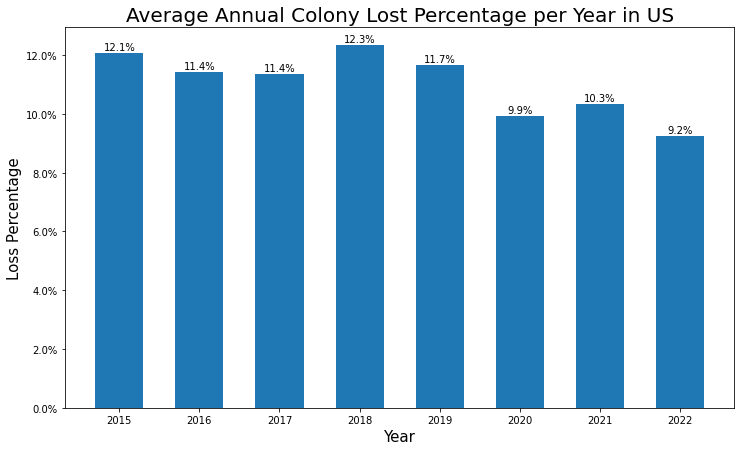

In [134]:
# creating a bar graph with appropriate labels and the title
fig, ax = plt.subplots(1, 1, figsize=(12,7))
b1 = ax.bar(by_year['year'], by_year['colony_lost_pct'], width=0.6)
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Loss Percentage", fontsize=15)
ax.set_title("Average Annual Colony Lost Percentage per Year in US", fontsize=20)

# change the y tick labels
yvals = ax.get_yticks()
ax.set_yticklabels([str(y) + "%" for y in yvals])

# label each bar
for bar in b1:
    height = bar.get_height()
    ax.annotate(f'{str(round(height, 1)) + "%"}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center')
plt.show()

### What is the colony loss percentage per season?

In [89]:
by_year_season.head(10)

,season,year,colony_lost_pct
0,summer,2015,10.044444
1,summer,2016,9.888889
2,summer,2017,8.577778
3,summer,2018,9.274074
4,summer,2019,10.888889
5,summer,2020,9.291045
6,summer,2021,8.626866
7,summer,2022,7.911111
8,winter,2015,14.108696
9,winter,2016,12.985507


In [90]:
seasons = ['summer', 'winter', 'annual']

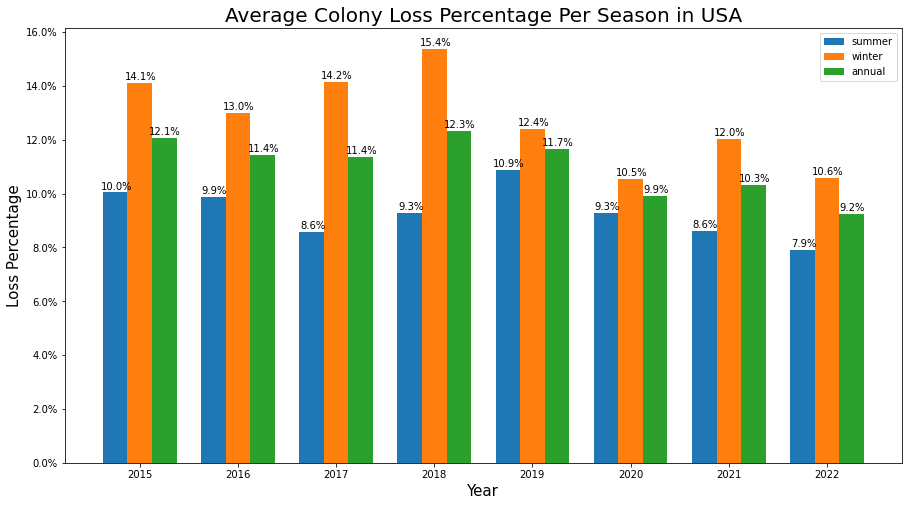

In [91]:
# create figure
fig, ax = plt.subplots(figsize=(15,8))

x = by_year['year']
width = 0.25

summer_bar = ax.bar(x - width, by_year_season[by_year_season['season'] == 'summer']['colony_lost_pct'], width, label='summer')
winter_bar = ax.bar(x, by_year_season[by_year_season['season'] == 'winter']['colony_lost_pct'], width, label='winter')
annual_bar = ax.bar(x + width, by_year_season[by_year_season['season'] == 'annual']['colony_lost_pct'], width, label='annual')

# add appropriate title and labels
ax.set_title("Average Colony Loss Percentage Per Season in USA", fontsize=20)
ax.set_xlabel("Year", fontsize=15)
ax.set_ylabel("Loss Percentage", fontsize=15)


# add percentage sign to the y tick label
ax.set_yticklabels([str(l)+"%" for l in ax.get_yticks()])

# add legend
ax.legend()

# annotate each bar
bars = [summer_bar, winter_bar, annual_bar]
for bar in bars:
    for b in bar:
        height = b.get_height()
        ax.annotate(f'{str(round(height, 1)) + "%"}',
                    xy=(b.get_x() + b.get_width() / 2, height),
                    xytext=(1, 3),
                    textcoords="offset points",
                    ha='center')
plt.show()

### What is the loss percentage per regions?

Is there any regions that has significantly higher colony loss?

In [92]:
# from https://gist.github.com/sfirrin/fd01d87f022d80e98c37a045c14109fe
states_to_regions = {
    'Washington': 'West', 'Oregon': 'West', 'California': 'West', 'Nevada': 'West',
    'Idaho': 'West', 'Montana': 'West', 'Wyoming': 'West', 'Utah': 'West',
    'Colorado': 'West', 'Alaska': 'West', 'Hawaii': 'West', 'Maine': 'Northeast',
    'Vermont': 'Northeast', 'New York': 'Northeast', 'New Hampshire': 'Northeast',
    'Massachusetts': 'Northeast', 'Rhode Island': 'Northeast', 'Connecticut': 'Northeast',
    'New Jersey': 'Northeast', 'Pennsylvania': 'Northeast', 'North Dakota': 'Midwest',
    'South Dakota': 'Midwest', 'Nebraska': 'Midwest', 'Kansas': 'Midwest',
    'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest', 'Wisconsin': 'Midwest',
    'Illinois': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Ohio': 'Midwest',
    'West Virginia': 'South', 'District of Columbia': 'South', 'Maryland': 'South',
    'Virginia': 'South', 'Kentucky': 'South', 'Tennessee': 'South', 'North Carolina': 'South',
    'Mississippi': 'South', 'Arkansas': 'South', 'Louisiana': 'South', 'Alabama': 'South',
    'Georgia': 'South', 'South Carolina': 'South', 'Florida': 'South', 'Delaware': 'South',
    'Arizona': 'Southwest', 'New Mexico': 'Southwest', 'Oklahoma': 'Southwest',
    'Texas': 'Southwest', 'Other States': 'other'}

In [93]:
colony_region = colony.states.map(states_to_regions)
colony.insert(3, 'region', colony_region)

In [94]:
per_region = colony[['region', 'colony_lost_pct']].groupby('region', as_index=False).mean()
per_region

,region,colony_lost_pct
0,Midwest,11.630108
1,Northeast,9.044280
2,South,12.790927
3,Southwest,13.771242
4,West,8.846821
5,other,13.363636


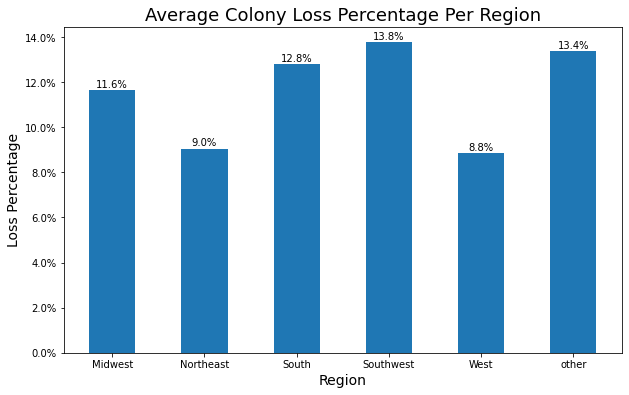

In [95]:
# create a bar plot
fig, ax = plt.subplots(figsize=(10,6))
b = ax.bar(per_region['region'], per_region['colony_lost_pct'], width=0.5)

# add labels
ax.set_title("Average Colony Loss Percentage Per Region", fontsize=18)
ax.set_ylabel("Loss Percentage", fontsize=14)
ax.set_xlabel("Region", fontsize=14)

# edit y tick labels
ax.set_yticklabels([str(l)+"%" for l in ax.get_yticks()])

#label each bar
for bar in b:
    height = bar.get_height()
    ax.annotate(f'{str(round(height, 1)) + "%"}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center')

plt.show()

### Do the states that suffered higher colony loss tend to add and renovate more colonies?

In [105]:
# correlation between loss and addition of colonies
df = colony[['colony_lost', 'colony_added']]
df.head()

,colony_lost,colony_added
0,1800.0,2800.0
1,4600.0,3400.0
2,1500.0,1200.0
3,255000.0,250000.0
4,1500.0,200.0


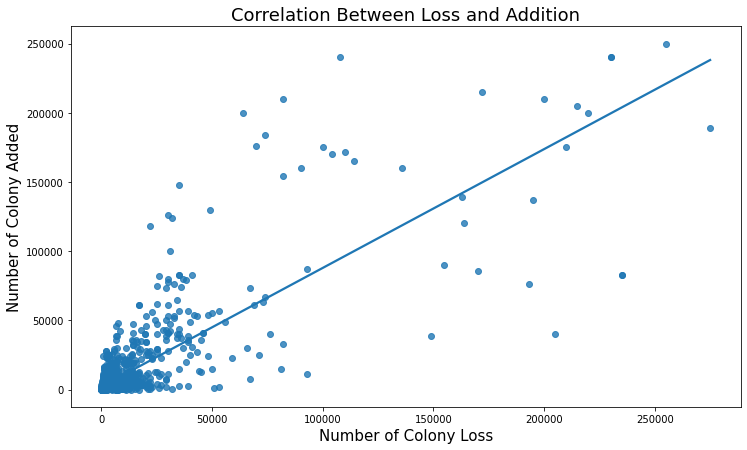

In [107]:
# create a scatter plot
fig, ax = plt.subplots(figsize=(12, 7))

# correlation line with appropriate labels
sns.regplot(df['colony_lost'], df['colony_added'], ci=None)
ax.set_title("Correlation Between Loss and Addition", fontsize=18)
ax.set_xlabel("Number of Colony Loss", fontsize=15)
ax.set_ylabel("Number of Colony Added", fontsize=15)

plt.show()

In [108]:
df.corr()

,colony_lost,colony_added
colony_lost,1.000000,0.810559
colony_added,0.810559,1.000000


In [109]:
# correlation between loss and renevation of colonies
df = colony[['colony_lost', 'colony_reno']]
df.head()

,colony_lost,colony_reno
0,1800.0,250.0
1,4600.0,2100.0
2,1500.0,90.0
3,255000.0,124000.0
4,1500.0,140.0


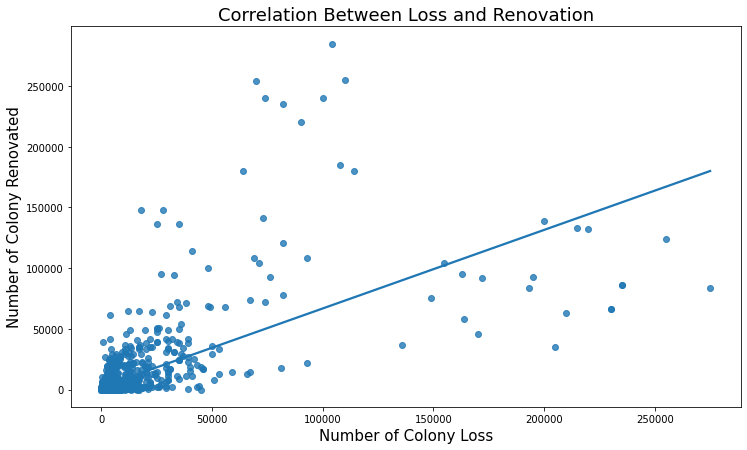

In [110]:
# create a scatter plot
fig, ax = plt.subplots(figsize=(12, 7))

# add appropriate labels
sns.regplot(df['colony_lost'], df['colony_reno'], ci=None)
ax.set_title("Correlation Between Loss and Renovation", fontsize=18)
ax.set_xlabel("Number of Colony Loss", fontsize=15)
ax.set_ylabel("Number of Colony Renovated", fontsize=15)

plt.show()

In [111]:
df.corr()

,colony_lost,colony_reno
colony_lost,1.000000,0.659655
colony_reno,0.659655,1.000000


States tend to add more colonies rather than renovate them. The correlation between `colony_lost` and `colony_add` is much higher than that of `colony_lost` and `colony_reno`.

## Stressor

In [112]:
# create season columns using month column
stressor_season = stressor['month'].map(month_mapping)
stressor.insert(2, 'season', stressor_season)
stressor.drop('month', axis=1, inplace=True)

In [113]:
# create region column using states column - using states_to_regions dictionary defined above
stressor_regions = stressor['states'].map(states_to_regions)
stressor.insert(3, 'region', stressor_regions)

In [114]:
stressor.head(10)

,year,season,states,region,stressor,stress_pct
0,2015,winter,Alabama,South,Varroa Mites,10.0
1,2015,winter,Alabama,South,Diseases,NaN
2,2015,winter,Alabama,South,Unknown,9.4
3,2015,winter,Alabama,South,Other,9.1
4,2015,winter,Alabama,South,Pesticides,2.2
5,2015,winter,Alabama,South,Other pests/parasites,5.4
6,2015,winter,Arizona,Southwest,Varroa Mites,26.9
7,2015,winter,Arizona,Southwest,Diseases,0.1
8,2015,winter,Arizona,Southwest,Unknown,3.1
9,2015,winter,Arizona,Southwest,Other pests/parasites,20.5


### What is the distribution of stressors percentage per season?

In [115]:
stressor_by_season = stressor[['season', 'stressor', 'stress_pct']].groupby(['season', 'stressor'], as_index=False).mean('stress_pct')
stressor_by_season

,season,stressor,stress_pct
0,summer,Diseases,4.237500
1,summer,Other,6.810123
2,summer,Other pests/parasites,12.623434
3,summer,Pesticides,7.686340
4,summer,Unknown,3.698062
5,summer,Varroa Mites,32.762878
6,winter,Diseases,3.288540
7,winter,Other,5.556082
8,winter,Other pests/parasites,9.236145
9,winter,Pesticides,4.610857


In [116]:
# create to different dataframes: one for summer and the other for winter
summer_df = stressor_by_season[stressor_by_season['season']=='summer']
winter_df = stressor_by_season[stressor_by_season['season']=='winter']

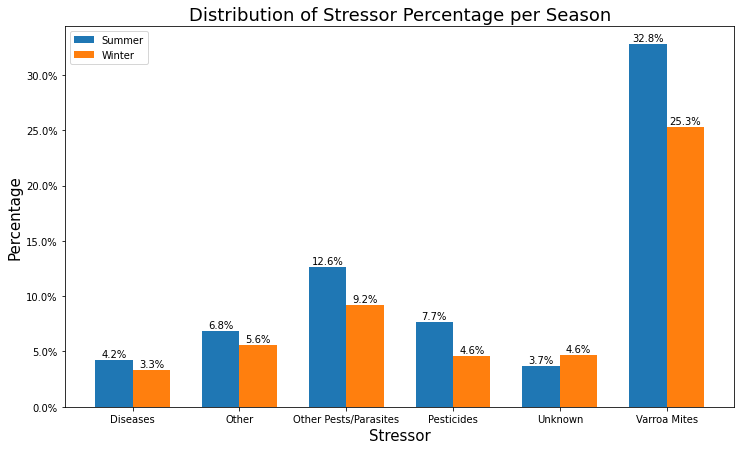

In [117]:
# create plot that contains two bar plots - summer and winter
fig, ax = plt.subplots(figsize=(12,7))
width = 0.35
x = np.arange(len(summer_df['stress_pct']))
labels = ['Diseases', 'Other', 'Other Pests/Parasites', 'Pesticides', 'Unknown', 'Varroa Mites']

# setting grouped bar chart
summer_bar = ax.bar(x-width/2, summer_df['stress_pct'], width, label='Summer')
winter_bar = ax.bar(x+width/2, winter_df['stress_pct'], width, label='Winter')

# set appropriate labels
ax.set_xticks(x, labels)
ax.set_title("Distribution of Stressor Percentage per Season", fontsize=18)
ax.set_xlabel("Stressor", fontsize=15)
ax.set_ylabel("Percentage", fontsize=15)
ax.set_yticklabels([str(l)+"%" for l in ax.get_yticks()])
ax.legend()

# label each bar
for season in [summer_bar, winter_bar]:
    for b in season:
        height = b.get_height()
        ax.annotate(f'{str(round(height, 1)) + "%"}',
                       xy=(b.get_x() + b.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center')

plt.show()

### What is the distribution of stressors percentage for each region?

In [118]:
stressor_by_region = stressor[['region', 'stressor', 'stress_pct']].groupby(['region', 'stressor'], as_index=False).mean('stress_pct')
stressor_by_region.head(10)

,region,stressor,stress_pct
0,Midwest,Diseases,3.628297
1,Midwest,Other,7.570833
2,Midwest,Other pests/parasites,9.906757
3,Midwest,Pesticides,7.792237
4,Midwest,Unknown,4.945495
5,Midwest,Varroa Mites,27.592918
6,Northeast,Diseases,2.654357
7,Northeast,Other,4.178113
8,Northeast,Other pests/parasites,5.185283
9,Northeast,Pesticides,3.706967


In [119]:
stressor['stressor'].unique()

array(['Varroa Mites', 'Diseases', 'Unknown', 'Other', 'Pesticides',
       'Other pests/parasites'], dtype=object)

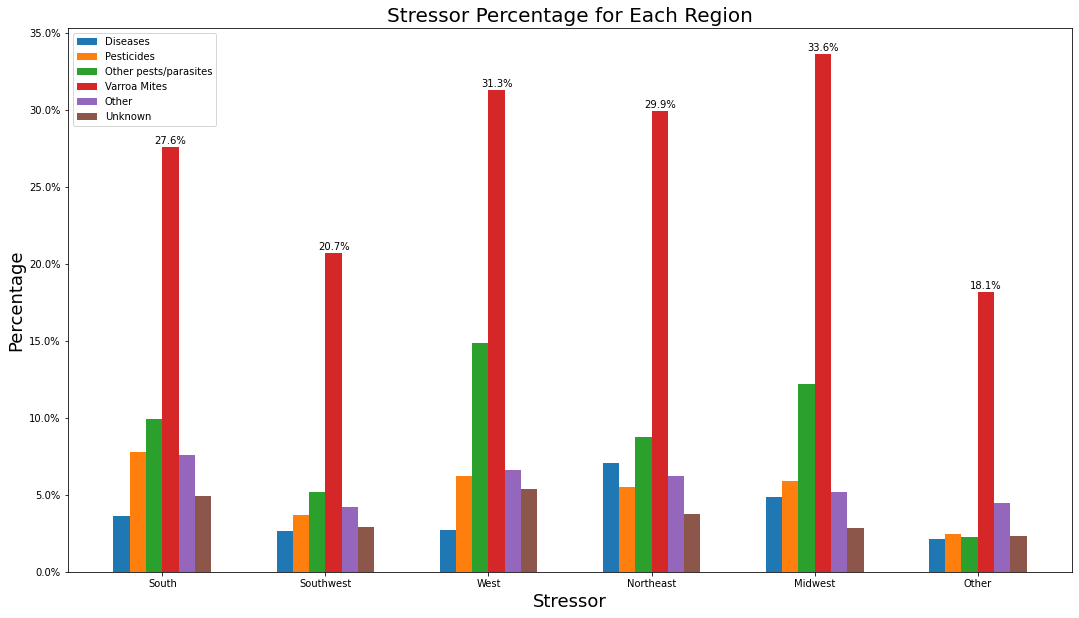

In [120]:
# create and specify bar chart size
fig, ax = plt.subplots(figsize=(18,10))
labels = pd.Series(stressor['region'].unique()).replace({'other':'Other'})
x = np.arange(len(labels))
width = 0.1

# create a grouped bar chart
diseases_bar = ax.bar(x-(width/2)-2*width, stressor_by_region[stressor_by_region['stressor']=='Diseases']['stress_pct'], width, label='Diseases')
pesticides_bar = ax.bar(x-(width/2)-width, stressor_by_region[stressor_by_region['stressor']=='Pesticides']['stress_pct'], width, label='Pesticides')
other_pest_bar = ax.bar(x-(width/2), stressor_by_region[stressor_by_region['stressor']=='Other pests/parasites']['stress_pct'], width, label='Other pests/parasites')
varroa_mite_bar = ax.bar(x+(width/2), stressor_by_region[stressor_by_region['stressor']=='Varroa Mites']['stress_pct'], width, label='Varroa Mites')
other_bar = ax.bar(x+(width/2)+width, stressor_by_region[stressor_by_region['stressor']=='Other']['stress_pct'], width, label='Other')
unknown_bar = ax.bar(x+(width/2)+2*width, stressor_by_region[stressor_by_region['stressor']=='Unknown']['stress_pct'], width, label='Unknown')

# add appropriate labels
ax.set_title('Stressor Percentage for Each Region', fontsize=20)
ax.set_xlabel('Stressor', fontsize=18)
ax.set_ylabel('Percentage', fontsize=18)
ax.legend(loc=2)

# edit tick labels
ax.set_yticklabels([str(l)+'%' for l in ax.get_yticks()])
ax.set_xticks(x, labels)

# only label varroa mite bar
for b in varroa_mite_bar:
    height = b.get_height()
    ax.annotate(f'{str(round(height, 1)) + "%"}',
                       xy=(b.get_x() + b.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center')

plt.show()

In [121]:
stressor_v2 = pd.pivot_table(stressor, values='stress_pct', index=['year', 'season', 'states'],columns=['stressor']).reset_index().rename_axis(None, axis=1)

In [122]:
# tip: use merge if you are not joining on the index
# joining the two datasets - colony and stressor
merged_df = colony.merge(stressor_v2, on=['year', 'season', 'states'])
merged_df.head(10)

,year,states,season,region,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_reno,colony_reno_pct,Diseases,Other,Other pests/parasites,Pesticides,Unknown,Varroa Mites
0,2015,Alabama,winter,South,7000.0,7000.0,1800.0,26.0,2800.0,250.0,4.0,0.2,5.95,5.90,1.20,5.65,6.55
1,2015,Alabama,winter,South,8000.0,8000.0,610.0,8.0,80.0,60.0,1.0,0.2,5.95,5.90,1.20,5.65,6.55
2,2015,Arizona,winter,Southwest,35000.0,35000.0,4600.0,13.0,3400.0,2100.0,6.0,0.6,1.15,11.10,3.50,9.30,38.50
3,2015,Arizona,winter,Southwest,36000.0,39000.0,12000.0,31.0,3000.0,16000.0,41.0,0.6,1.15,11.10,3.50,9.30,38.50
4,2015,Arkansas,winter,South,13000.0,14000.0,1500.0,11.0,1200.0,90.0,1.0,0.8,4.75,10.55,5.80,0.80,27.85
5,2015,Arkansas,winter,South,23000.0,27000.0,2400.0,9.0,1900.0,0.0,0.0,0.8,4.75,10.55,5.80,0.80,27.85
6,2015,California,winter,West,1440000.0,1690000.0,255000.0,15.0,250000.0,124000.0,7.0,4.6,8.50,9.95,9.60,5.05,31.00
7,2015,California,winter,West,750000.0,1260000.0,149000.0,12.0,39000.0,75000.0,6.0,4.6,8.50,9.95,9.60,5.05,31.00
8,2015,Colorado,winter,West,3500.0,12500.0,1500.0,12.0,200.0,140.0,1.0,11.5,5.50,12.65,10.15,3.85,31.10
9,2015,Colorado,winter,West,24000.0,24000.0,2500.0,10.0,3400.0,0.0,0.0,11.5,5.50,12.65,10.15,3.85,31.10


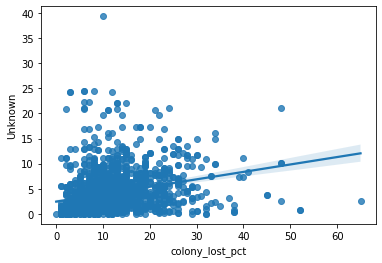

In [123]:
sns.regplot(x=merged_df['colony_lost_pct'], y=merged_df['Unknown'])
plt.show()

In [124]:
merged_df[['colony_lost_pct', 'Unknown']].corr()

,colony_lost_pct,Unknown
colony_lost_pct,1.000000,0.273791
Unknown,0.273791,1.000000


## Colony Loss (Map)

In [125]:
# from https://gist.github.com/rogerallen/1583593

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [126]:
state_code = merged_df.states.map(us_state_to_abbrev)
merged_df['state_code'] = state_code

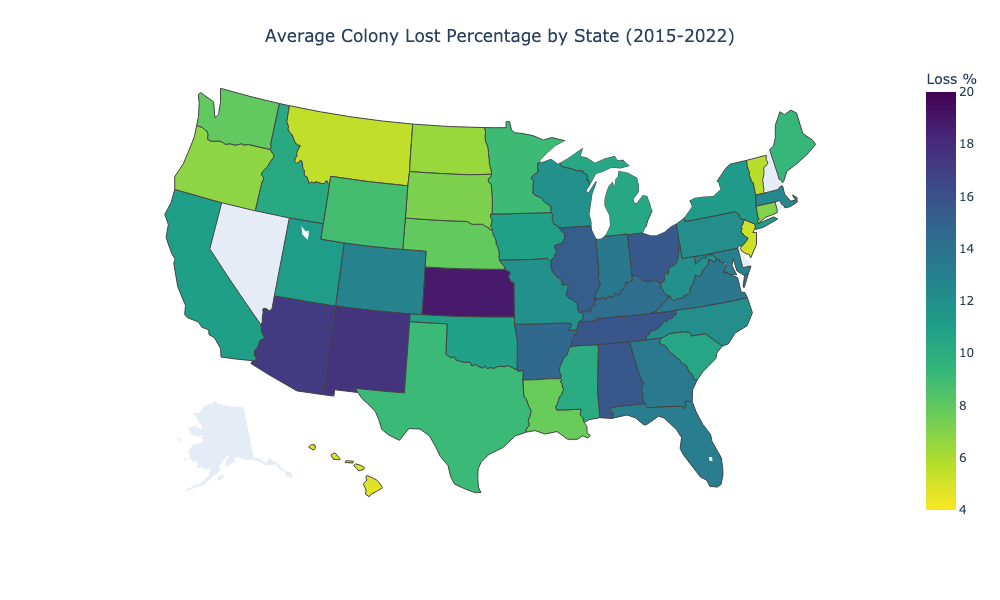

In [127]:
# choropleth map by U.S. States

map_df = merged_df[['state_code', 'colony_lost_pct']].groupby('state_code', as_index=False).mean()

fig = px.choropleth(map_df,
                    locations='state_code',
                    locationmode='USA-states',
                    scope='usa',
                    color='colony_lost_pct',
                    range_color=(4,20),
                    color_continuous_scale='Viridis_r',
                    labels={'colony_lost_pct': 'Loss %'})

fig.update_layout(
    title={'text': 'Average Colony Lost Percentage by State (2015-2022)',
           'xanchor': 'center',
           'yanchor': 'top',
           'x': 0.5})

# fig.add_scattergeo(
#   locations = map_df['state_code'],
#   locationmode='USA-states',
#   text = [str(round(x,1))+'%' for x in map_df['colony_lost_pct'] if not pd.isna(x)],
#   mode = 'text')


fig.show(renderer='png', height=600, width=1000)

In [129]:
merged_df.head()

,year,states,season,region,colony_n,colony_max,colony_lost,colony_lost_pct,colony_added,colony_reno,colony_reno_pct,Diseases,Other,Other pests/parasites,Pesticides,Unknown,Varroa Mites,state_code
0,2015,Alabama,winter,South,7000.0,7000.0,1800.0,26.0,2800.0,250.0,4.0,0.2,5.95,5.90,1.2,5.65,6.55,AL
1,2015,Alabama,winter,South,8000.0,8000.0,610.0,8.0,80.0,60.0,1.0,0.2,5.95,5.90,1.2,5.65,6.55,AL
2,2015,Arizona,winter,Southwest,35000.0,35000.0,4600.0,13.0,3400.0,2100.0,6.0,0.6,1.15,11.10,3.5,9.30,38.50,AZ
3,2015,Arizona,winter,Southwest,36000.0,39000.0,12000.0,31.0,3000.0,16000.0,41.0,0.6,1.15,11.10,3.5,9.30,38.50,AZ
4,2015,Arkansas,winter,South,13000.0,14000.0,1500.0,11.0,1200.0,90.0,1.0,0.8,4.75,10.55,5.8,0.80,27.85,AR


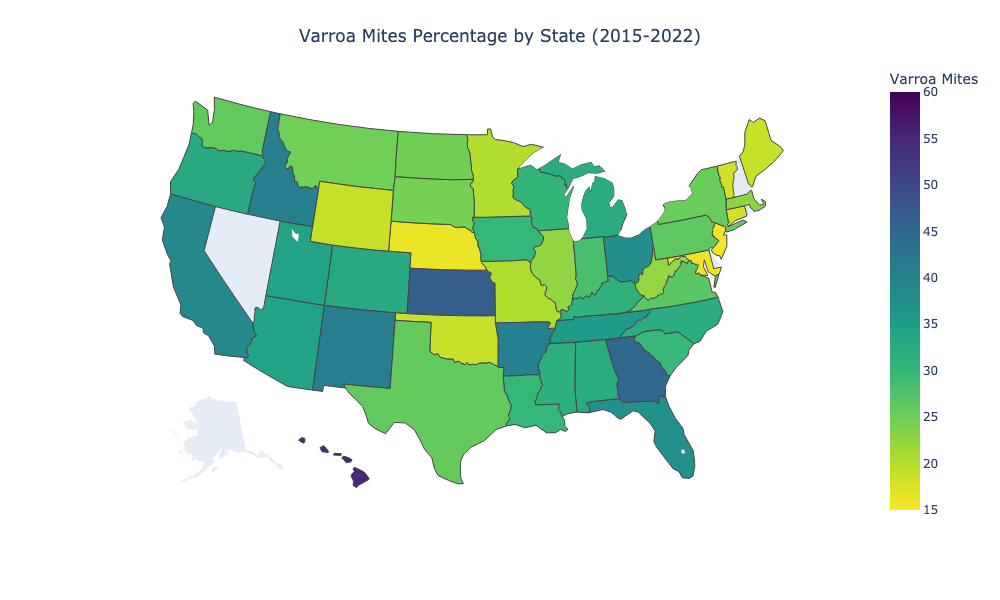

In [133]:
# varroa mite affect over the map

map_df = merged_df[['state_code', 'Varroa Mites']].groupby('state_code', as_index=False).mean()

fig = px.choropleth(map_df,
                    locations='state_code',
                    locationmode='USA-states',
                    scope='usa',
                    color='Varroa Mites',
                    range_color=(15,60),
                    color_continuous_scale='Viridis_r',
                    labels={'Varroa Mites': 'Varroa Mites'})

fig.update_layout(
    title={'text': 'Varroa Mites Percentage by State (2015-2022)',
           'xanchor': 'center',
           'yanchor': 'top',
           'x': 0.5})

# fig.add_scattergeo(
#   locations = map_df['state_code'],
#   locationmode='USA-states',
#   text = [str(round(x,1))+'%' for x in map_df['colony_lost_pct'] if not pd.isna(x)],
#   mode = 'text')


fig.show(renderer='png', height=600, width=1000)